In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [2]:
X= pd.read_csv('../input/data-science-london-scikit-learn/train.csv',header=None)

In [3]:
y= pd.read_csv('../input/data-science-london-scikit-learn/trainLabels.csv',header=None)

In [4]:
y=y[0]

In [5]:
y.shape

(1000,)

In [6]:
X.shape

(1000, 40)

In [7]:
X.isnull().sum().sum()

0

Now we are sure that X is 2 dimensional np array and y is 1 dimensional np array and there is no missing data, lets check normal distribution of independent variables X

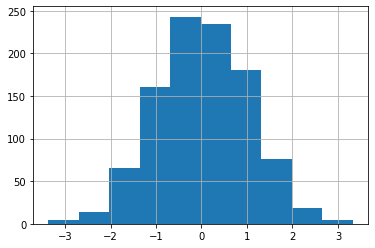

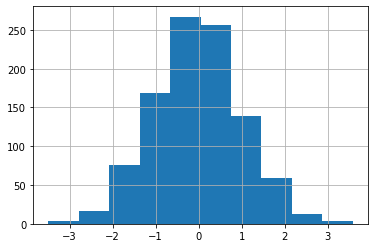

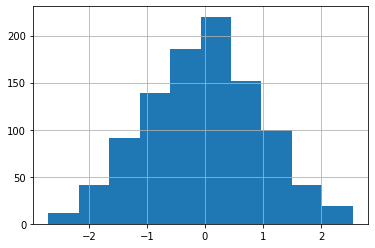

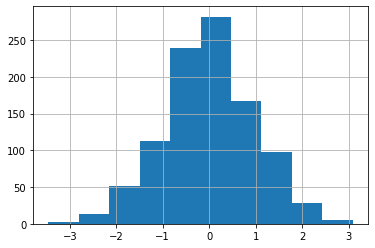

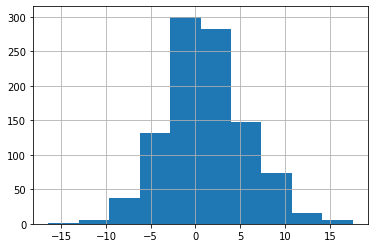

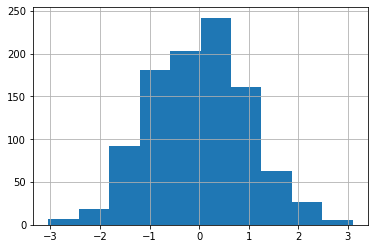

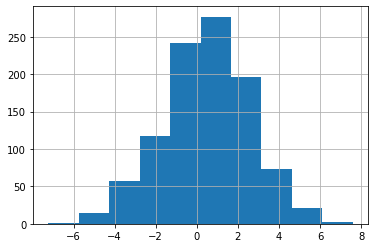

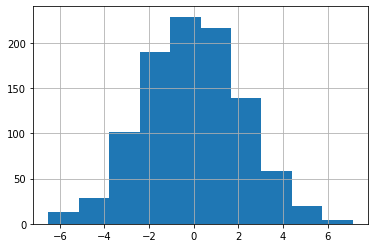

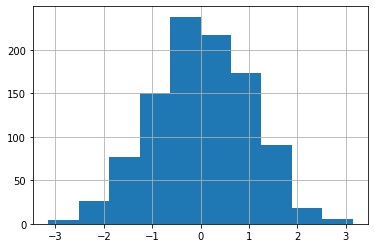

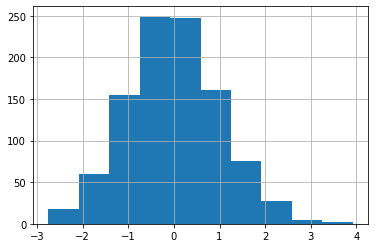

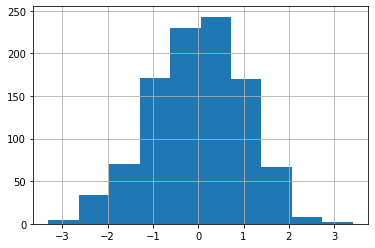

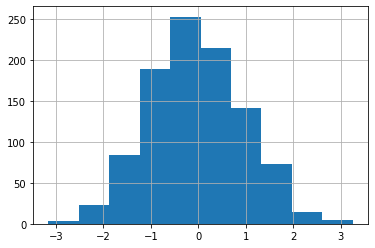

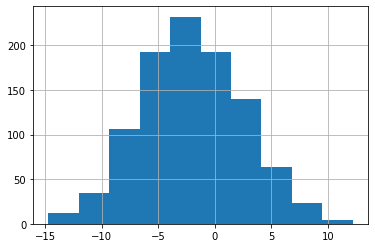

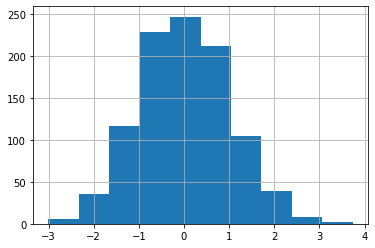

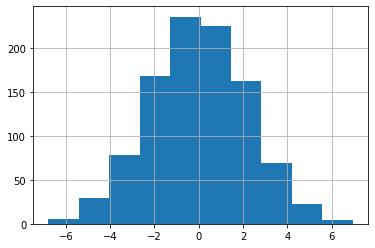

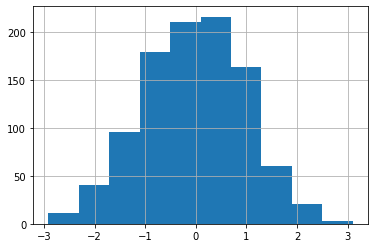

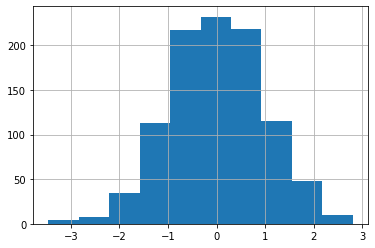

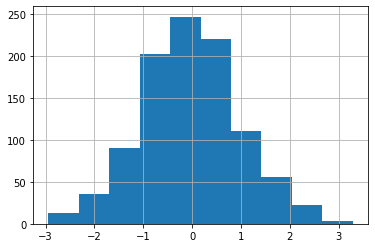

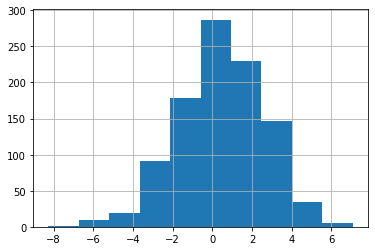

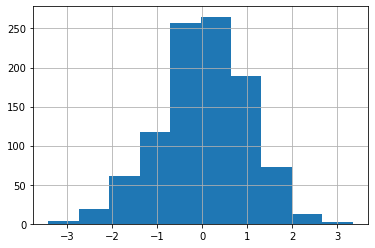

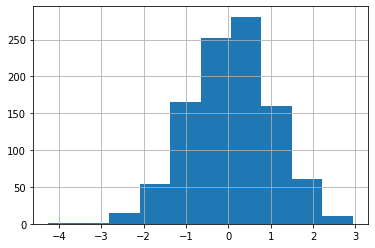

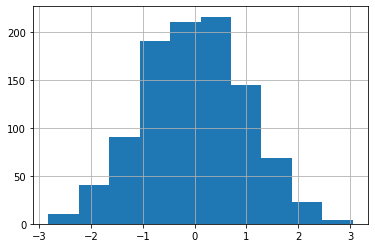

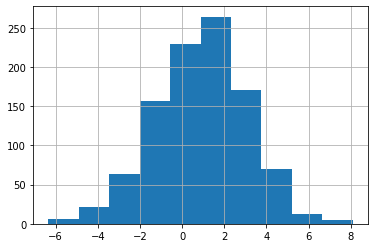

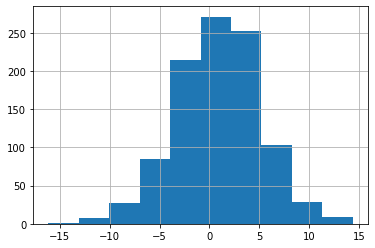

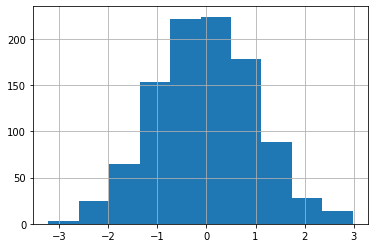

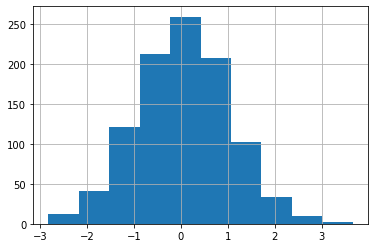

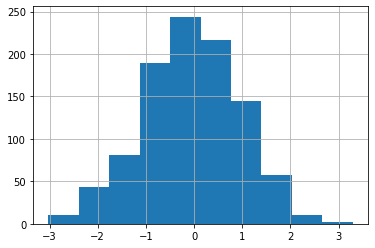

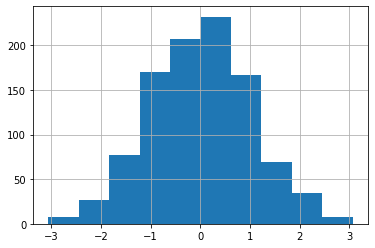

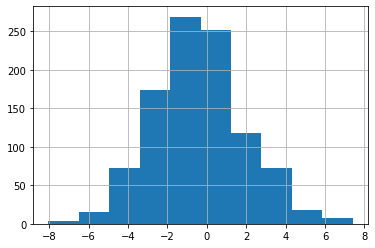

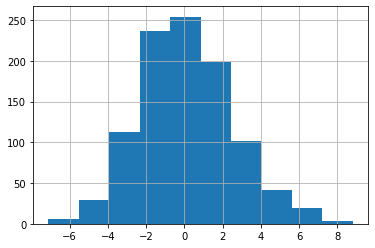

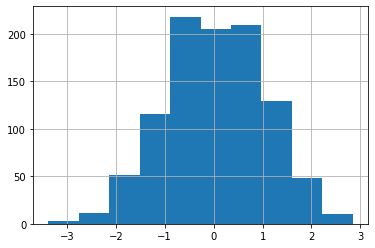

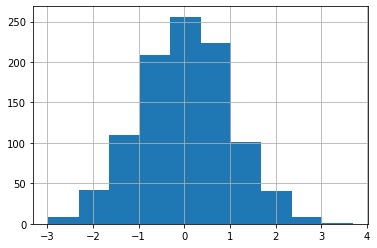

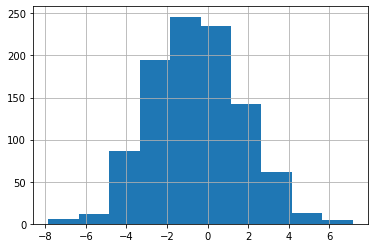

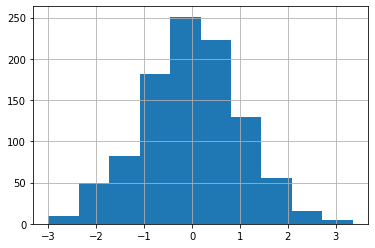

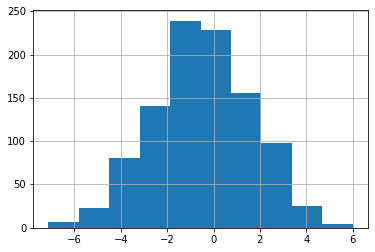

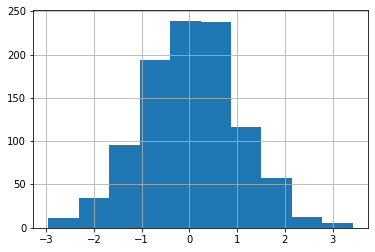

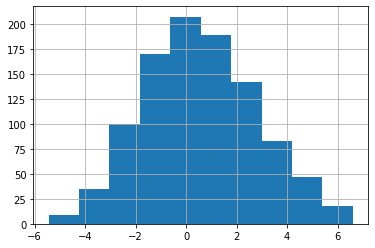

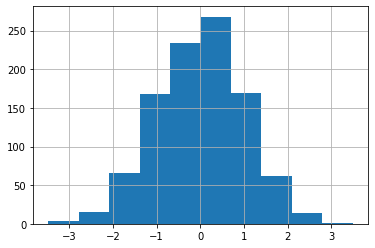

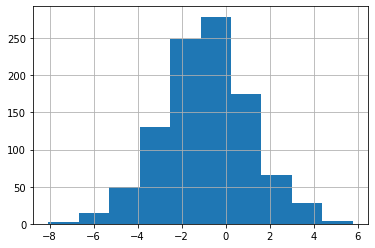

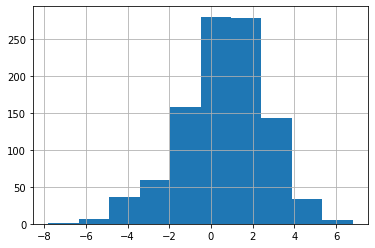

In [8]:
for column in X.columns:
    X[column].hist()
    plt.show()

All 40 columns are normally distributed, hence logistic regression and support vector machine, works just fine, also i will try two ensble methods, adaboost and randomforest

In [9]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.025596,-0.024526,-0.024088,-0.002271,1.092329,-0.006250,0.497342,-0.037883,0.026391,-0.003597,...,0.030651,0.022951,-0.542491,-0.011608,-0.483507,0.033371,0.567185,0.006849,-0.892659,0.609451
std,1.008282,1.016298,0.979109,0.970575,4.538834,0.989128,2.118819,2.232256,1.001064,1.013520,...,1.011645,1.001375,2.239939,1.022456,2.121281,1.007044,2.227876,0.997635,2.022022,2.045439
min,-3.365711,-3.492086,-2.695602,-3.460471,-16.421901,-3.041250,-7.224761,-6.509084,-3.145588,-2.749812,...,-3.379194,-2.971125,-7.840890,-2.999564,-7.124105,-2.952358,-5.452254,-3.473913,-8.051722,-7.799086
25%,-0.669010,-0.693937,-0.698830,-0.617557,-1.801997,-0.732265,-0.838619,-1.604037,-0.677562,-0.682220,...,-0.659457,-0.696032,-2.121943,-0.664550,-1.879247,-0.642861,-1.059786,-0.691162,-2.220126,-0.565041
50%,0.027895,-0.033194,0.008145,0.002327,0.862818,0.027041,0.582321,0.018809,0.022092,-0.036110,...,0.049416,0.049778,-0.568262,-0.028097,-0.493575,0.037732,0.455474,0.038284,-0.855470,0.779944
75%,0.762520,0.682753,0.661434,0.640743,3.843172,0.671456,1.913664,1.438304,0.741310,0.665364,...,0.747031,0.699917,0.939348,0.651374,1.005795,0.691800,2.122157,0.693535,0.388698,1.992193
max,3.326246,3.583870,2.546507,3.088738,17.565345,3.102997,7.592666,7.130097,3.145258,3.919426,...,2.844792,3.688047,7.160379,3.353631,6.005818,3.420561,6.603499,3.492548,5.774120,6.803984


Also, all data seems to have close range, no need for using `MINMAXSCALER()`

Next, lets define a function that takes a predefined number of estimators and train-test split, fit and predict for a specefic number of times, and compare the results

Note: the following function is not very simple, as it can used any where, so i wrote it in a generic way

In [10]:
def estimators_repeater(estimators=[RandomForestClassifier(),AdaBoostClassifier(),SVC()],tr_slicer=(None,None),tst_slicer=(None,None),loops=500,scorer=accuracy_score,X=X,y=y):
    '''This function aims to train list of supplied estimators with selcted slices of datasets for as many time as required(default 500)
    and then produce a list of training score, test score and time used for each estimator
    
    - It is important to import all used estimators, score to be used
    inputs :
    - estimators : a list of estimators, deafult is Randomforest, Adaboost and support vector machine
    
    - tr_slicer : slicer for the number of observations needed in the training, default is all samples [:], slicer should be tuples
    of integers(starter,ender) default is(None,None)
    
    - tst_slicer : slicer for the number of samples to be tested at, default is all samples [0:-1], slicer should be tuples
    of integers(starter,ender) default is(0,-1)
    
    -loops : int, is a number of loops needed : default 500
    
    -scorer : default is accuracy_score, but it can be anything choosen from sklearn.metrics but if it is something calculated by
    methods other than accuracy, it should be modified in the 
    
    -X= features in the form of dataframe or np.array of 2 dimensions
    -y= target in the form of dataframe, series or np.array
    
    Returns : 3 global dataframes for training score(training_score_df),
    testing score(testing_score_df) and time (time_df) used for each estimator for fitting and predicting
    
    
    Example, fitting first 200 samples for SVC() and RandomForestClassifier() for 400 loop and scorer is accuracy for full test dataset:
    
    estimators_repeater(estimators=[RandomForestClassifier(),SVC()],tr_slicer=(0,200),loops=400,scorer=accuracy_score,X=X,y=y)
    
    '''
    
    training_score={}
    testing_score={}
    timing={}
    for clf in estimators:
        clf_name = clf.__class__.__name__
        training_score[clf_name]=[]
        testing_score[clf_name]=[]
        timing[clf_name]=[]
       
    for i in range (loops):
        k1=time()
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        for clf in estimators:
            a=time()
            clf_name = clf.__class__.__name__
            clean_clf=clone(clf)
            clean_clf.fit(X_train[tr_slicer[0]:tr_slicer[1]],y_train[tr_slicer[0]:tr_slicer[1]])
            training_score[clf_name].append(scorer(y_train[tr_slicer[0]:tr_slicer[1]],clean_clf.predict(X_train[tr_slicer[0]:tr_slicer[1]])))
            testing_score[clf_name].append(scorer(y_test[tst_slicer[0]:tst_slicer[1]],clean_clf.predict(X_test[tst_slicer[0]:tst_slicer[1]])))
            b=time()
            timing[clf_name].append(b-a)
        k2=time()
        print(f'loop number {i} out of {loops} took {k2-k1} seconds')
    
    global training_score_df
    training_score_df=pd.DataFrame(training_score)
    global testing_score_df
    testing_score_df=pd.DataFrame(testing_score)
    global timing_df
    timing_df=pd.DataFrame(timing)

A simple apply to the above function would be below as follows:

* test split data 
* fit X, and y for randomforest, adaboost, SVC and logestic regression
* record the time for the above steps, also record test data score and record train data score
* Do the above 500 times
* the final output would be 3 dataframes, one for the test_Scores, and one for train scores, and last one for time consumed for each loop

In [11]:
estimators_repeater(estimators=[RandomForestClassifier(), AdaBoostClassifier(), SVC(),LogisticRegression()],X=X,y=y)

loop number 0 out of 500 took 0.8646328449249268 seconds
loop number 1 out of 500 took 0.9244742393493652 seconds
loop number 2 out of 500 took 0.8925325870513916 seconds
loop number 3 out of 500 took 0.9039895534515381 seconds
loop number 4 out of 500 took 0.8985481262207031 seconds
loop number 5 out of 500 took 0.9275369644165039 seconds
loop number 6 out of 500 took 0.9148828983306885 seconds
loop number 7 out of 500 took 0.9035553932189941 seconds
loop number 8 out of 500 took 0.9019131660461426 seconds
loop number 9 out of 500 took 0.9083094596862793 seconds
loop number 10 out of 500 took 0.9045546054840088 seconds
loop number 11 out of 500 took 0.904918909072876 seconds
loop number 12 out of 500 took 0.9061031341552734 seconds
loop number 13 out of 500 took 0.9445023536682129 seconds
loop number 14 out of 500 took 0.9119410514831543 seconds
loop number 15 out of 500 took 0.9416217803955078 seconds
loop number 16 out of 500 took 0.9345028400421143 seconds
loop number 17 out of 500

In [12]:
training_score_df.describe()

,RandomForestClassifier,AdaBoostClassifier,SVC,LogisticRegression
count,500.0,500.000000,500.000000,500.000000
mean,1.0,0.898992,0.950213,0.840451
std,0.0,0.009029,0.004435,0.008347
min,1.0,0.876000,0.936000,0.817333
25%,1.0,0.893333,0.946667,0.834667
50%,1.0,0.898667,0.950667,0.840667
75%,1.0,0.905333,0.953333,0.845333
max,1.0,0.926667,0.962667,0.868000


It seems for training score, randomforest rocks ( which is expected), folloed by SVC

In [13]:
testing_score_df.describe()

,RandomForestClassifier,AdaBoostClassifier,SVC,LogisticRegression
count,500.000000,500.000000,500.000000,500.000000
mean,0.863096,0.780344,0.894472,0.813400
std,0.020355,0.024518,0.017924,0.021834
min,0.800000,0.696000,0.828000,0.752000
25%,0.848000,0.764000,0.884000,0.799000
50%,0.864000,0.780000,0.894000,0.812000
75%,0.880000,0.796000,0.908000,0.828000
max,0.920000,0.852000,0.936000,0.872000


As for testing score, it seems SVC is the best with average score of 0.894472

In [14]:
timing_df.describe()

,RandomForestClassifier,AdaBoostClassifier,SVC,LogisticRegression
count,500.000000,500.000000,500.000000,500.000000
mean,0.519239,0.313106,0.063908,0.037177
std,0.019644,0.010491,0.003073,0.009725
min,0.440644,0.294351,0.058333,0.023252
25%,0.505325,0.305269,0.062066,0.033314
50%,0.515764,0.311266,0.063432,0.034977
75%,0.528916,0.318853,0.065182,0.037404
max,0.644900,0.375808,0.090582,0.109035


it seems randomforest classifier took average of 0.5 second per fit,predict cycle, while adaboost took 0.3 second while SVC took 0.06 second ! 

So i will use SVC for final submission

In [15]:
testing_score_df.sort_values(by='SVC',ascending=False)

,RandomForestClassifier,AdaBoostClassifier,SVC,LogisticRegression
303,0.892,0.792,0.936,0.852
194,0.920,0.808,0.936,0.848
179,0.908,0.820,0.936,0.836
82,0.896,0.812,0.936,0.828
190,0.888,0.780,0.932,0.836
...,...,...,...,...
406,0.836,0.756,0.852,0.796
174,0.836,0.792,0.852,0.808
33,0.804,0.728,0.852,0.764
35,0.820,0.752,0.848,0.808


In [16]:
# initiate SVC instance with random_state that get the most svc score from the predefined function
prediction=SVC(random_state=303)

In [17]:
# fitting whole test.csv and trainlabel.csv
prediction.fit(X,y)

SVC(random_state=303)

In [18]:
# defining test data that will be predicted for submission
test_data= pd.read_csv('../input/data-science-london-scikit-learn/test.csv',header=None)

In [19]:
predictions=prediction.predict(test_data)

In [20]:
# constructing of submission dataframe
df=pd.DataFrame()
df['Id']=[i for i in range(1,9001)]
df['Solution']=predictions

In [21]:
df.tail()

,Id,Solution
8995,8996,1
8996,8997,1
8997,8998,1
8998,8999,0
8999,9000,1


In [22]:
df.to_csv('submission.csv',index=False)

Final submission get me **0.89819** which consider good, as i didn't use gridsearch